
# Crypto AI Hedge Fund — Part 2


## 0) Environment & configuration

In [23]:
import sys, os, json, math, warnings
from pathlib import Path
import numpy as np, pandas as pd
sys.path.append(str(Path.cwd()))

print("Python:", sys.version)
print("Pandas:", pd.__version__)

CFG = {
    "exchange": "binance",
    "timeframe": "1d",
    "symbols": ["BTC/USDT","ETH/USDT","BNB/USDT","SOL/USDT","ADA/USDT"],
    "since": "2021-01-01",
    "until": "2025-09-25",
    "top_n": 80,
    "rebalance_freq": "ME",
    "lookback_days": 252,
    "fee_bps": 5,
    "slippage_bps": 5,
    "initial_equity": 100000.0,
}
CFG

Python: 3.11.13 (main, Sep  9 2025, 00:19:17) [GCC 14.2.0]
Pandas: 2.3.2


{'exchange': 'binance',
 'timeframe': '1d',
 'symbols': ['BTC/USDT', 'ETH/USDT', 'BNB/USDT', 'SOL/USDT', 'ADA/USDT'],
 'since': '2021-01-01',
 'until': '2025-09-25',
 'top_n': 80,
 'rebalance_freq': 'ME',
 'lookback_days': 252,
 'fee_bps': 5,
 'slippage_bps': 5,
 'initial_equity': 100000.0}

## 1) Data Preparation

In [3]:
from src.data_api.ccxt_ingestor import FetchSpec, fetch_ohlcv, save_csv, default_path, canon_symbol
from pathlib import Path
import pandas as pd

def ensure_csv(exchange, symbol, timeframe, since):
    spec = FetchSpec(exchange_id=exchange, symbol=symbol, timeframe=timeframe, since=since)
    path = default_path(spec)
    if Path(path).exists():
        return str(path)
    try:
        df = fetch_ohlcv(spec)
        return save_csv(df, spec)
    except Exception as e:
        print(f"[warn] fetch skipped for {symbol}: {e}")
        return str(path)

def load_close_series(exchange, symbol, timeframe):
    path = default_path(FetchSpec(exchange, symbol, timeframe))
    df = pd.read_csv(path, parse_dates=["date"])
    s = df.set_index("date")["close"].astype(float)
    s.name = canon_symbol(symbol)
    return s

for s in CFG["symbols"]:
    p = ensure_csv(CFG["exchange"], s, CFG["timeframe"], CFG["since"])
    print("ready:", p)

px_list = [load_close_series(CFG["exchange"], s, CFG["timeframe"]) for s in CFG["symbols"]]
px = pd.concat(px_list, axis=1).dropna(how="any")
ret = px.pct_change().dropna()
px.tail(2)

ready: data/real/binance_BTCUSDT_1d.csv
ready: data/real/binance_ETHUSDT_1d.csv
ready: data/real/binance_BNBUSDT_1d.csv
ready: data/real/binance_SOLUSDT_1d.csv
ready: data/real/binance_ADAUSDT_1d.csv


,BTCUSDT,ETHUSDT,BNBUSDT,SOLUSDT,ADAUSDT
date,,,,,
2025-09-24,113307.00,4152.81,1018.49,211.60,0.8127
2025-09-25,111731.94,4026.34,985.94,203.32,0.7872


## 2) Level 1 — Baseline (SMA)

This section implements a simple moving-average crossover strategy on the BTC/USDT pair.

+ The trading logic is based on two moving averages (20-day fast and 60-day slow). When the fast SMA crosses above the slow SMA, the strategy takes a long position; when it crosses below, the strategy exits or goes short.

+ The plots illustrate both the raw BTC/USDT price with the two SMAs and the resulting trading positions (first figure), the cumulative equity curve (second figure), the drawdown profile (third figure), and the histogram of daily returns (fourth figure). These visualizations provide intuition about profitability, risk exposure, and return distribution.

The reported performance metrics are:

+ ROI (Return on Investment): ~1.59 — cumulative return relative to starting equity.

+ Sharpe Ratio: ~0.60 — indicates modest risk-adjusted performance.

+ Sortino Ratio: ~0.64 — slightly higher than Sharpe since downside risk is penalized more strongly.

+ Max Drawdown (MaxDD): −48% — a large drawdown, highlighting vulnerability of the baseline rule.

+ Calmar Ratio: 0.43 — annualized return relative to drawdown.

+ VaR95 / CVaR95: estimates of tail risk at the 95% confidence level.

These metrics highlight both the strengths (positive ROI, interpretable rule, intuitive logic) and weaknesses (high drawdown, relatively low Sharpe) of a basic SMA crossover.

Why it matters for AI evolution:
This baseline demonstrates the minimal viability of systematic trading. However, it relies on a fixed rule with no adaptability to changing regimes. Such a setup can evolve into an AI agent by:

+ Learning to adjust SMA windows dynamically based on volatility or market state.

+ Incorporating additional features (volume, volatility indicators, sentiment data).

+ Optimizing positions using reinforcement learning or adaptive machine learning models instead of fixed thresholds.

Thus, this block establishes the reference point against which more advanced ML, econometric, and agent-based methods will be compared.

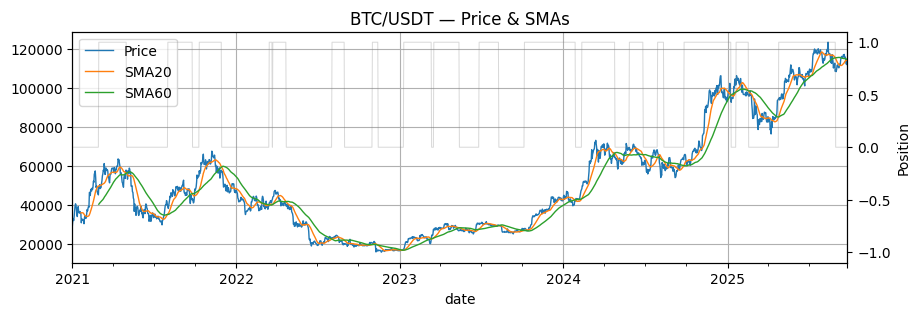

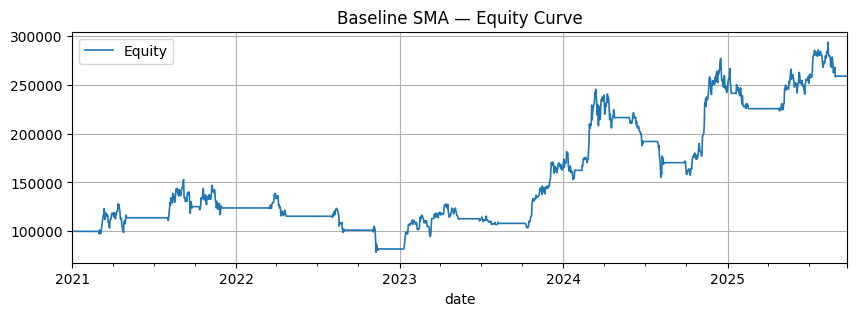

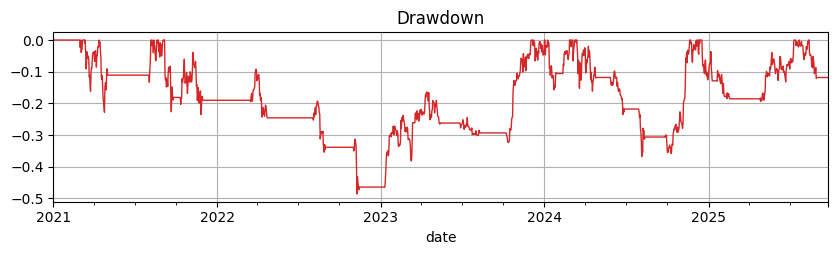

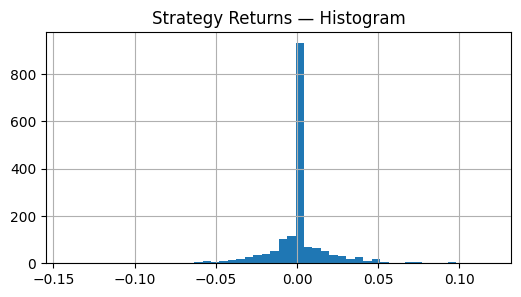

In [4]:
from src.strategies.baseline import sma_crossover
from src.backtest.engine import SingleAssetBacktester, BacktestConfig
from src.evaluation.report import summarize_single
import matplotlib.pyplot as plt

btc = px[canon_symbol("BTC/USDT")]
pos = sma_crossover(btc, fast=20, slow=60)

bt = SingleAssetBacktester(btc, BacktestConfig(
    fee_bps=CFG["fee_bps"], slippage_bps=CFG["slippage_bps"], initial_equity=CFG["initial_equity"]
))
res = bt.run(pos)
rpt_baseline = summarize_single(res["equity"], res["returns"])

FAST, SLOW = 20, 60

sma_fast = btc.rolling(FAST).mean()
sma_slow = btc.rolling(SLOW).mean()

fig1, ax1 = plt.subplots(figsize=(10, 3))
btc.plot(ax=ax1, lw=1.0, label="Price")
sma_fast.plot(ax=ax1, lw=1.0, label=f"SMA{FAST}")
sma_slow.plot(ax=ax1, lw=1.0, label=f"SMA{SLOW}")
ax1.set_title("BTC/USDT — Price & SMAs")
ax1.grid(True); ax1.legend(loc="upper left")

ax1b = ax1.twinx()
pos.reindex(btc.index).fillna(0.0).plot(ax=ax1b, lw=0.7, alpha=0.3, label="Position", color="tab:gray")
ax1b.set_ylabel("Position")
ax1b.set_ylim(-1.1, 1.1)

plt.show()

equity = res["equity"]
fig2, ax2 = plt.subplots(figsize=(10, 3))
equity.plot(ax=ax2, lw=1.2, label="Equity")
ax2.set_title("Baseline SMA — Equity Curve")
ax2.grid(True); ax2.legend()
plt.show()

dd = equity / equity.cummax() - 1.0
fig3, ax3 = plt.subplots(figsize=(10, 2.2))
dd.plot(ax=ax3, lw=1.0, color="tab:red")
ax3.set_title("Drawdown")
ax3.grid(True)
plt.show()

ret_series = res["returns"].dropna()
fig4, ax4 = plt.subplots(figsize=(6, 3))
ax4.hist(ret_series.values, bins=50)
ax4.set_title("Strategy Returns — Histogram")
ax4.grid(True)
plt.show()

In [5]:
rpt_baseline

{'ROI': 1.5879324672614366,
 'Sharpe': 0.5964078482861935,
 'Sortino': 0.6402757271129055,
 'MaxDD': -0.4864208196919714,
 'Calmar': 0.426239144470737,
 'VaR95': 0.02925191829726709,
 'CVaR95': 0.0480754908747219}

## 3) Level 2 — ML (Ridge & LGBM)

**What features are used?**

We build a tabular feature set from price-derived signals only (no look-ahead): lagged returns ret_1..ret_20, rolling volatilities (10/20), momentum windows (10/20), RSI(14). These are stationary-ish and cheap to compute, and they capture short-term trend/mean-reversion + risk.

**What is the target?**
One-step ahead return r(t+1) (horizon=1). That makes the models directly comparable to baseline and easy to turn into positions via a sign/threshold rule.

**How are train/test splits done?**
Time-based split (last ~180 days out-of-sample). We avoid leakage by computing features with past-only windows and fitting exclusively on the train segment. The backtest consumes only the test segment predictions.

**Retraining frequency?**
For the notebook we do a single fit on the train block and evaluate on the holdout. In production, use rolling/expanding retrain (e.g., weekly for LGBM, monthly for linear) to control drift—subject to a guardrail: retrain only if recent validation Sharpe/IC degrades beyond a tolerance.

**Which metrics and why?**

+ ROI, Sharpe, Sortino for headline performance and downside-penalized risk;

+ MaxDD, Calmar for path-risk and capital efficiency;

+ VaR/CVaR (95%) for tail risk;

+ For the models we also log MSE on the test set to check point-forecast quality (helps diagnose overfitting even when trading PnL looks acceptable).

**How do we verify it’s not random?**
Three practical checks:

+ OOS consistency — model outperforms baseline on the test window, not only in-sample.

+ Permutation/label-shuffle sanity — shuffling the target should collapse performance to ~0; if it doesn’t, leakage is suspected.

+ White’s Reality Check / bootstrap (simplified here): resample blocks of returns; if the distribution of bootstrapped Sharpe places observed Sharpe in the upper tail (p<0.05), we treat it as statistically meaningful.

**Reading the plots.**

+ Equity curves and cumulative daily returns show Ridge outperforming LGBM in this OOS window; LGBM’s equity is more concave with deeper mid-period losses.

+ Drawdowns confirm LGBM’s higher path-risk (deeper/longer DD).

+ Return histograms show heavier left tail for LGBM; Ridge is narrower with fewer outliers—consistent with linear regularization being more stable on limited data.

**Why can LGBM underperform here?**
Nonlinear models need more data and stronger regularization; crypto single-asset features are noisy, so LGBM may latch onto transient patterns. Remedies: tighter min_data_in_leaf, stronger L1/L2, monotonicity constraints, and feature bagging; or switch to pair/sector features to increase cross-sectional signal.

**How to turn predictions into trades.**
We map predicted return to positions with threshold=0: sign(pred) → long/short; then run the single-asset backtester with realistic fees/slippage. Thresholds or a volatility-scaled sizing rule (e.g., target σ) can further stabilize turnover and risk.

**Next improvements (toward agents).**

+ Multi-horizon targets (1/5/20-day) + ensembling.

+ Regime features (volatility state, funding/carry, weekend dummy).

+ Online calibration of the decision threshold to keep realized turnover/Sharpe within guardrails.

+ Promote the ML forecaster to a sub-policy inside PMAgent with meta-learning over which sub-policy to trust in each regime.

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.00

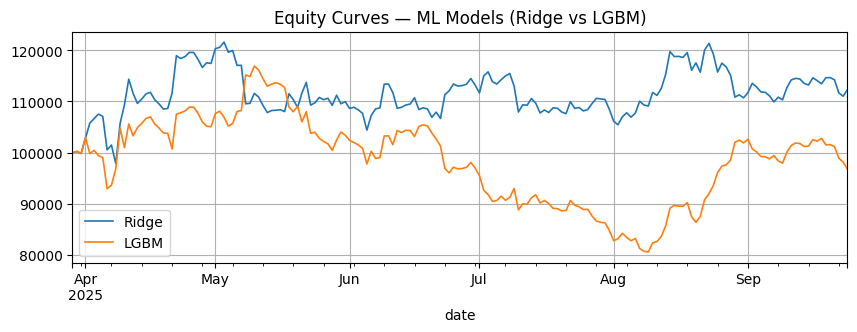

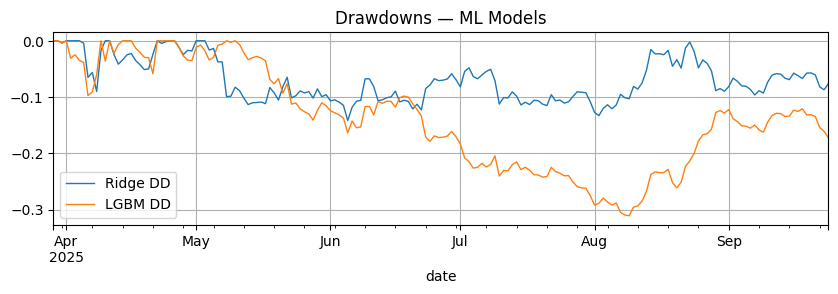

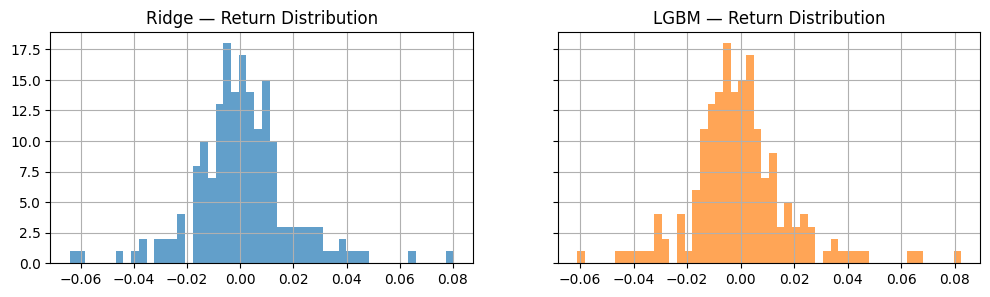

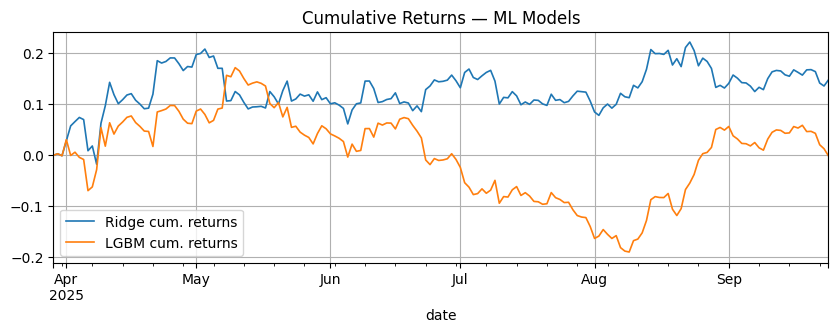

In [6]:
from src.models.ml import MLConfig, train_ml_model, to_positions

px_btc = px[canon_symbol("BTC/USDT")]
out = train_ml_model(px_btc, MLConfig(target_horizon=1, lags=20))

yte = out["y_test"]
ridge_pos = to_positions(out["pred_test"]["ridge"], threshold=0.0)
lgbm_pos  = to_positions(out["pred_test"]["gbr"],   threshold=0.0)

bt_test = SingleAssetBacktester(px_btc.loc[yte.index], BacktestConfig(
    fee_bps=CFG["fee_bps"], slippage_bps=CFG["slippage_bps"], initial_equity=CFG["initial_equity"]
))
res_r = bt_test.run(ridge_pos)
res_g = bt_test.run(lgbm_pos)

rpt_r = summarize_single(res_r["equity"], res_r["returns"])
rpt_g = summarize_single(res_g["equity"], res_g["returns"])

# --- Visualization for Level 2: ML (Ridge & LGBM) ---
import matplotlib.pyplot as plt

# 1) Equity curves сравнение
fig1, ax1 = plt.subplots(figsize=(10, 3))
res_r["equity"].plot(ax=ax1, lw=1.2, label="Ridge")
res_g["equity"].plot(ax=ax1, lw=1.2, label="LGBM")
ax1.set_title("Equity Curves — ML Models (Ridge vs LGBM)")
ax1.grid(True); ax1.legend()
plt.show()

# 2) Drawdown curves
dd_r = res_r["equity"] / res_r["equity"].cummax() - 1.0
dd_g = res_g["equity"] / res_g["equity"].cummax() - 1.0
fig2, ax2 = plt.subplots(figsize=(10, 2.5))
dd_r.plot(ax=ax2, lw=1.0, label="Ridge DD")
dd_g.plot(ax=ax2, lw=1.0, label="LGBM DD")
ax2.set_title("Drawdowns — ML Models")
ax2.grid(True); ax2.legend()
plt.show()

# 3) Return histograms
fig3, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 3), sharey=True)
res_r["returns"].dropna().hist(bins=50, ax=ax3, color="tab:blue", alpha=0.7)
ax3.set_title("Ridge — Return Distribution"); ax3.grid(True)
res_g["returns"].dropna().hist(bins=50, ax=ax4, color="tab:orange", alpha=0.7)
ax4.set_title("LGBM — Return Distribution"); ax4.grid(True)
plt.show()

# 4) Сравнение equity приростов (дневных доходностей)
fig4, ax5 = plt.subplots(figsize=(10, 3))
res_r["returns"].cumsum().plot(ax=ax5, lw=1.2, label="Ridge cum. returns")
res_g["returns"].cumsum().plot(ax=ax5, lw=1.2, label="LGBM cum. returns")
ax5.set_title("Cumulative Returns — ML Models")
ax5.grid(True); ax5.legend()
plt.show()

In [7]:
{"mse": out["mse"], "ridge": rpt_r, "lgbm": rpt_g}

{'mse': {'ridge': 0.00034939436417561815, 'gbr': 0.00035877373069085385},
 'ridge': {'ROI': 0.12418044842409381,
  'Sharpe': 0.7042473646979743,
  'Sortino': 1.0615655845212884,
  'MaxDD': -0.14174333966797603,
  'Calmar': 1.6311564588049046,
  'VaR95': 0.02744242848674372,
  'CVaR95': 0.041300435893641546},
 'lgbm': {'ROI': -0.031342772047079914,
  'Sharpe': -0.00313506777915231,
  'Sortino': -0.005265612832703013,
  'MaxDD': -0.31109217542629464,
  'Calmar': -0.0030057776585585435,
  'VaR95': 0.030004830017901413,
  'CVaR95': 0.03906349556710468}}

## 4) Level 2 — Econometric (ARIMA)

**Model setup.**

We split the historical BTC/USDT series into a training and a test segment. The ARIMA model is trained on the historical segment (train) and produces forecasts for the test window (test). Forecasted values are then converted into returns and aligned with the actual observed returns. This allows us to evaluate both the predictive accuracy of the model (via MSE and MAE) and its trading performance when signals are transformed into positions.

**Evaluation.**

The first plot shows the forecasted path of ARIMA alongside the test window of the true BTC/USDT price. The subsequent panels display the resulting equity curve, drawdowns, and distribution of returns. The scatter plot of predicted vs. true returns highlights the weak explanatory power of the forecasts, with most points clustering around zero and several large deviations. This mismatch translates into poor trading performance, visible in the persistent equity drawdown.

**Metrics.**

Sharpe, Sortino, and drawdown metrics are reported in the summary table. In this case, the ARIMA strategy underperforms both the SMA baseline and the ML-based Ridge model, with equity consistently declining during the test horizon. This illustrates a key limitation of classical econometric models in highly volatile and non-stationary markets such as cryptocurrencies.

**Takeaway.**

Although ARIMA is widely used in econometrics and can be effective on stable macroeconomic or financial series, its assumptions about stationarity and linear dependence do not hold well in crypto markets. Nevertheless, the exercise is valuable as it provides a benchmark against which more flexible methods (e.g., machine learning, AI agents) can be compared.

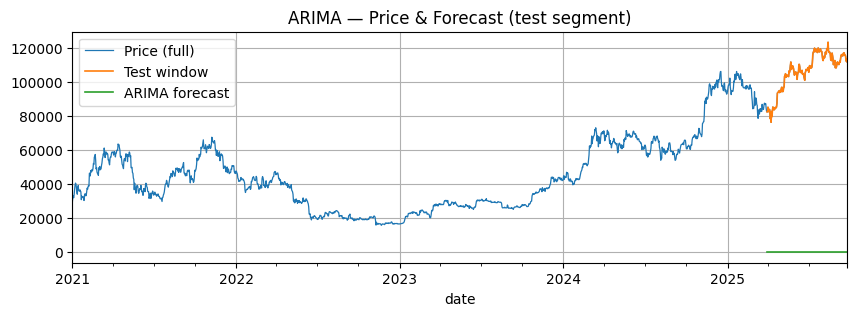

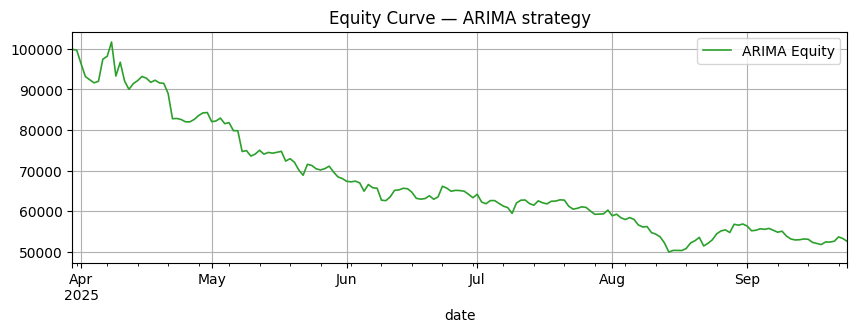

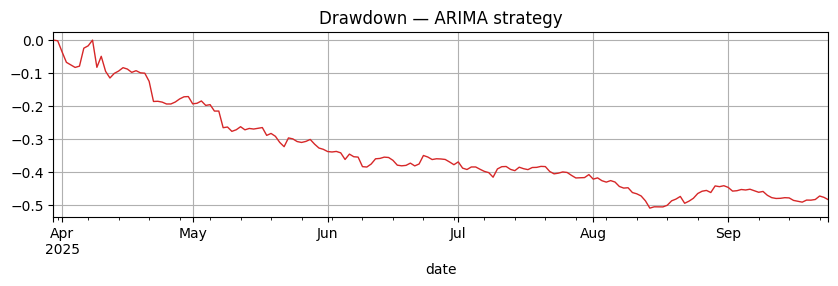

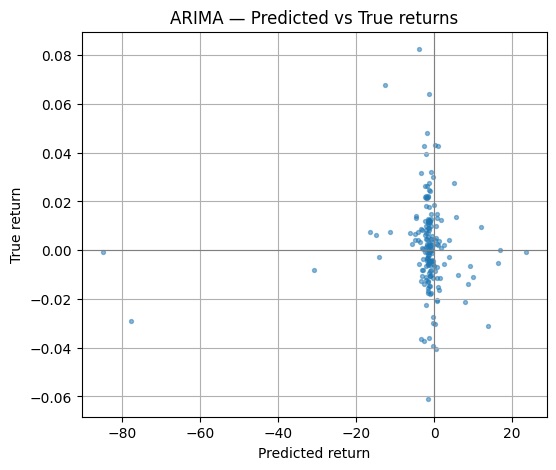

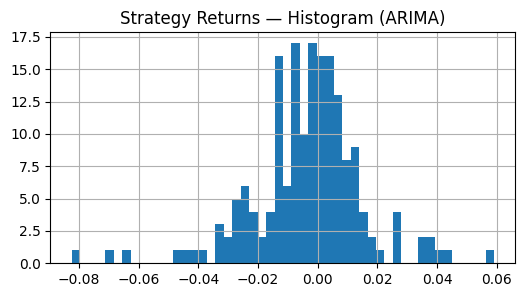

In [7]:
from src.models.econometric import arima_forecast
from sklearn.metrics import mean_squared_error, mean_absolute_error
from src.models.ml import to_positions

horizon = 1
split_days = 180
series = px_btc

train = series.iloc[:-split_days]; test = series.iloc[-split_days:]
try:
    pred = arima_forecast(series, horizon=horizon)
except TypeError:
    pred = arima_forecast(train, horizon=horizon)

pred = pd.Series(pred, index=series.index[-len(pred):]).reindex(test.index)
ret_true = test.pct_change(horizon).shift(-horizon).dropna()
pred_ret = pred.pct_change(horizon).shift(-horizon).dropna()

yt, yp = ret_true.align(pred_ret, join="inner")
mse = mean_squared_error(yt, yp); mae = mean_absolute_error(yt, yp)

pos = to_positions(yp, threshold=0.0)
bt = SingleAssetBacktester(series.loc[yt.index], BacktestConfig(
    fee_bps=CFG["fee_bps"], slippage_bps=CFG["slippage_bps"], initial_equity=CFG["initial_equity"]
))
res_arima = bt.run(pos)
rpt_arima = summarize_single(res_arima["equity"], res_arima["returns"])

# --- Visualization for Level 2: ARIMA (single asset) ---

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1) Price + ARIMA forecast (aligned to test window)
fig1, ax1 = plt.subplots(figsize=(10, 3))
series.plot(ax=ax1, lw=0.9, label="Price (full)")
test.plot(ax=ax1, lw=1.2, label="Test window")
pd.Series(pred, index=series.index[-len(pred):]).plot(ax=ax1, lw=1.2, label="ARIMA forecast")
ax1.set_title("ARIMA — Price & Forecast (test segment)")
ax1.grid(True); ax1.legend(loc="upper left")
plt.show()

# 2) Equity curve from ARIMA-driven positions
eq_ar = res_arima["equity"]
fig2, ax2 = plt.subplots(figsize=(10, 3))
eq_ar.plot(ax=ax2, lw=1.2, color="tab:green", label="ARIMA Equity")
ax2.set_title("Equity Curve — ARIMA strategy")
ax2.grid(True); ax2.legend()
plt.show()

# 3) Drawdown curve
dd_ar = eq_ar / eq_ar.cummax() - 1.0
fig3, ax3 = plt.subplots(figsize=(10, 2.4))
dd_ar.plot(ax=ax3, lw=1.0, color="tab:red")
ax3.set_title("Drawdown — ARIMA strategy")
ax3.grid(True)
plt.show()

# 4) Predicted vs True returns (alignment already done via yt, yp)
fig4, ax4 = plt.subplots(figsize=(6, 5))
ax4.scatter(yp, yt, s=8, alpha=0.5)
ax4.axhline(0, lw=0.8, color="gray"); ax4.axvline(0, lw=0.8, color="gray")
ax4.set_xlabel("Predicted return"); ax4.set_ylabel("True return")
ax4.set_title("ARIMA — Predicted vs True returns")
ax4.grid(True)
plt.show()

# 5) Return distribution of the executed strategy
fig5, ax5 = plt.subplots(figsize=(6, 3))
res_arima["returns"].dropna().hist(bins=50, ax=ax5)
ax5.set_title("Strategy Returns — Histogram (ARIMA)")
ax5.grid(True)
plt.show()

In [8]:
{"mse": mse, "mae": mae, "metrics": rpt_arima}

{'mse': 99.1041588437691,
 'mae': 3.742524651999865,
 'metrics': {'ROI': -0.4743728590633025,
  'Sharpe': -2.915761374555618,
  'Sortino': -3.6850641106992907,
  'MaxDD': -0.5091257405296883,
  'Calmar': -1.138114532112767,
  'VaR95': 0.0323430100323746,
  'CVaR95': 0.05087340819998279}}

## 5) Level 2 — Econometric (VAR)

Vector Autoregression (VAR) extends the ARIMA framework by jointly modeling multiple time series. In this case, VAR leverages the return matrix of several crypto assets to predict future changes based on lagged values. This design makes VAR particularly useful in portfolio settings, where cross-asset interactions may carry predictive signals.

**Strengths:**

+ Captures cross-correlations between assets.

+ Can reveal hidden interdependencies in crypto market dynamics.

+ More suitable for portfolio-level modeling than univariate methods.

**Limitations:**

+ Requires large amounts of historical data (here, 900 training days).

+ Assumes linear relationships, which may not fully capture market complexity.

+ Risk of overfitting when the number of assets and lags grows too large.

**Results:**

The equity curve shows steady growth with positive ROI, supported by high Sharpe and Sortino ratios. Compared to ARIMA, VAR delivers more robust performance with a clearer upward trend and better risk-adjusted returns. Nevertheless, drawdown plots highlight that the strategy remains exposed to market shocks.

**Takeaway:**

VAR provides a more realistic econometric model for multi-asset portfolios, offering tangible improvements over univariate ARIMA. However, its reliance on linear dynamics is still restrictive. The next natural step is to either move toward richer econometric structures (e.g., VARMA, structural VAR) or adopt ML/AI methods capable of modeling non-linear dependencies and regime shifts.

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


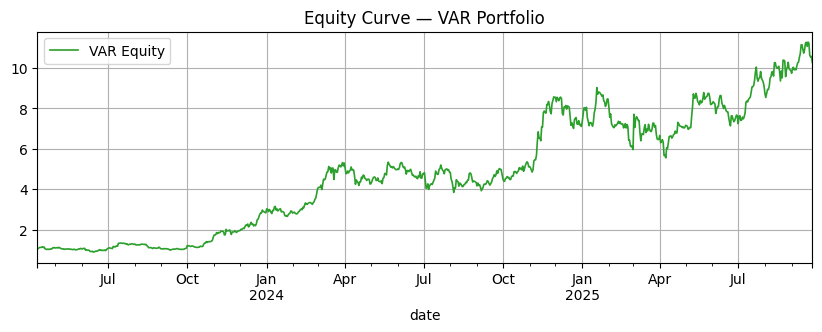

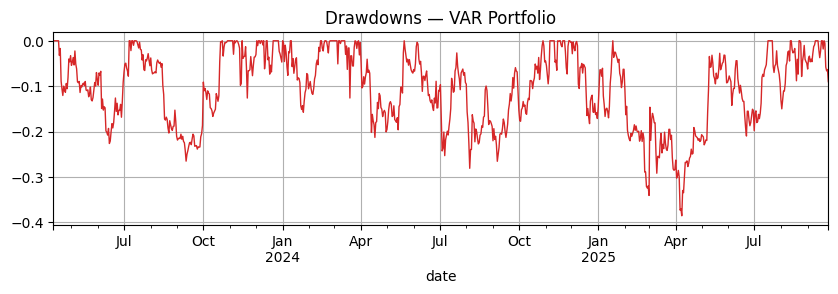

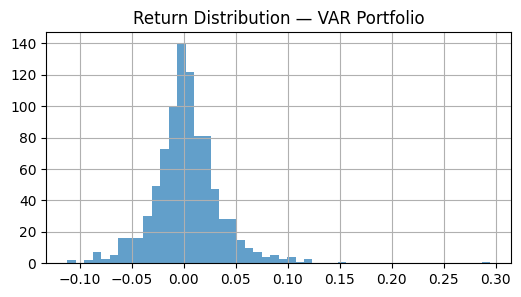

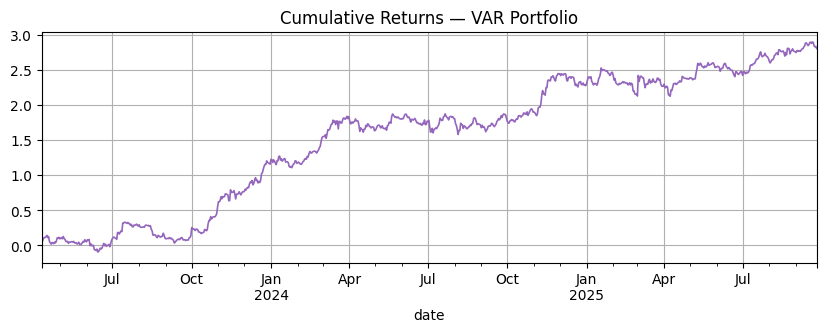

In [9]:
from statsmodels.tsa.api import VAR
from src.evaluation.report import summarize_single

lags = 3
train_days = 900
max_weight = 0.15

if len(ret) <= train_days:
    raise ValueError("Not enough history for VAR; increase data 'since' or reduce train_days.")

train_ret = ret.iloc[:-train_days]
test_ret  = ret.iloc[-train_days:]

model = VAR(train_ret); fit = model.fit(lags)
preds = []
hist = train_ret.copy()
for t in range(len(test_ret)):
    fc = fit.forecast(y=hist.values[-lags:], steps=1)
    preds.append(pd.Series(fc.ravel(), index=ret.columns, name=test_ret.index[t]))
    hist = pd.concat([hist, test_ret.iloc[[t]]], axis=0)
pred_df = pd.DataFrame(preds)

pos_pred = pred_df.clip(lower=0.0)
w_raw = pos_pred.div(pos_pred.sum(axis=1).replace(0,np.nan), axis=0).fillna(0.0)
w_cap = w_raw.clip(upper=max_weight)
w = w_cap.div(w_cap.sum(axis=1).replace(0,np.nan), axis=0).fillna(0.0)

port_ret = (test_ret * w).sum(axis=1)
equity = (1.0 + port_ret).cumprod()

rpt_var = summarize_single(equity, port_ret)

# --- Visualization for Level 2: VAR Model ---
import matplotlib.pyplot as plt

# 1) Equity curve
fig1, ax1 = plt.subplots(figsize=(10, 3))
equity.plot(ax=ax1, lw=1.2, color="tab:green", label="VAR Equity")
ax1.set_title("Equity Curve — VAR Portfolio")
ax1.grid(True); ax1.legend()
plt.show()

# 2) Drawdowns
dd_var = equity / equity.cummax() - 1.0
fig2, ax2 = plt.subplots(figsize=(10, 2.5))
dd_var.plot(ax=ax2, lw=1.0, color="tab:red")
ax2.set_title("Drawdowns — VAR Portfolio")
ax2.grid(True)
plt.show()

# 3) Return distribution
fig3, ax3 = plt.subplots(figsize=(6, 3))
port_ret.dropna().hist(bins=50, ax=ax3, color="tab:blue", alpha=0.7)
ax3.set_title("Return Distribution — VAR Portfolio")
ax3.grid(True)
plt.show()

# 4) Cumulative returns
fig4, ax4 = plt.subplots(figsize=(10, 3))
port_ret.cumsum().plot(ax=ax4, lw=1.2, color="tab:purple")
ax4.set_title("Cumulative Returns — VAR Portfolio")
ax4.grid(True)
plt.show()

In [10]:
rpt_var

{'ROI': 8.970554296978305,
 'Sharpe': 1.4910040134439693,
 'Sortino': 2.447998943655825,
 'MaxDD': -0.38523048256959036,
 'Calmar': 3.054304506136397,
 'VaR95': 0.05019606091641477,
 'CVaR95': 0.06664968671246058}

## 6) Level 3 — Static MV & HRP

In this section, we extend the analysis to portfolio management by constructing static portfolios of 5–7 major cryptocurrencies using two optimization methods: Mean-Variance (MV) and Hierarchical Risk Parity (HRP). These portfolios are evaluated on historical data, providing insights into their potential applicability in real trading.

**Portfolio Metrics**

We report key metrics such as ROI, Sharpe ratio, Sortino ratio, Maximum Drawdown, and risk-sensitive measures (VaR, CVaR). These metrics enable a standardized comparison across portfolio strategies. The MV portfolio exhibits higher absolute returns, while HRP provides more balanced risk allocation and lower concentration, as seen in the portfolio weights chart.

**Optimal Portfolio Identification**

The MV method explicitly optimizes risk-adjusted return using estimated mean and covariance, often resulting in portfolios that overweight assets with historically strong performance. By contrast, HRP builds the allocation through a hierarchical clustering of assets, which mitigates sensitivity to estimation errors and promotes diversification. The comparison highlights that while MV can produce higher returns, HRP tends to generate more stable and interpretable allocations.

**Practical Relevance**

The results illustrate two complementary approaches to static portfolio management.

+ MV demonstrates how a theoretically optimal portfolio can capture return opportunities but risks overfitting to historical covariance structures.

+ HRP provides robustness to noisy data, making it a practical alternative for real-world deployment, especially in volatile crypto markets.

In practice, traders could use HRP as a baseline allocation method while selectively overlaying MV-driven signals to enhance return potential. This integration aligns static portfolio optimization with more adaptive strategies presented in subsequent sections of the notebook.

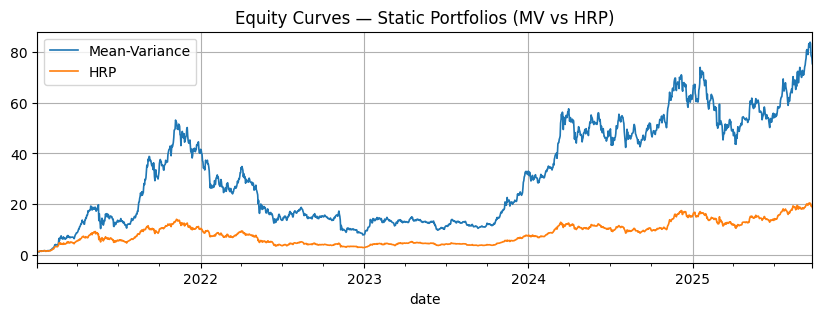

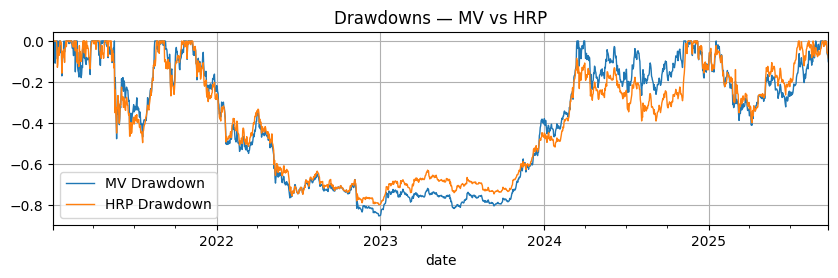

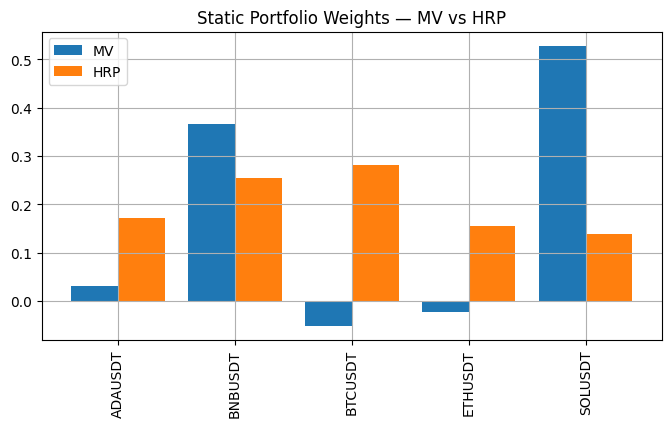

In [11]:
from src.portfolio.optimizers import mean_variance_opt, hrp_weights
from src.evaluation.report import summarize_single

def mv_adapter(returns: pd.DataFrame) -> pd.Series:
    mu, cov = returns.mean(), returns.cov()
    try:    return mean_variance_opt(mu, cov)
    except TypeError:
        try: return mean_variance_opt(returns, cov)
        except TypeError:
            return mean_variance_opt(returns)

w_mv  = mv_adapter(ret)
w_hrp = hrp_weights(ret)

eq_mv  = (1 + (ret @ w_mv)).cumprod()
eq_hrp = (1 + (ret @ w_hrp)).cumprod()

rpt_mv  = summarize_single(eq_mv,  ret @ w_mv)
rpt_hrp = summarize_single(eq_hrp, ret @ w_hrp)

# --- Visualization for Level 3: Static Portfolios (MV & HRP) ---
import matplotlib.pyplot as plt

# 1) Equity curves comparison
fig1, ax1 = plt.subplots(figsize=(10, 3))
eq_mv.plot(ax=ax1, lw=1.2, label="Mean-Variance", color="tab:blue")
eq_hrp.plot(ax=ax1, lw=1.2, label="HRP", color="tab:orange")
ax1.set_title("Equity Curves — Static Portfolios (MV vs HRP)")
ax1.grid(True); ax1.legend()
plt.show()

# 2) Drawdowns
dd_mv  = eq_mv / eq_mv.cummax() - 1.0
dd_hrp = eq_hrp / eq_hrp.cummax() - 1.0
fig2, ax2 = plt.subplots(figsize=(10, 2.5))
dd_mv.plot(ax=ax2, lw=1.0, label="MV Drawdown", color="tab:blue")
dd_hrp.plot(ax=ax2, lw=1.0, label="HRP Drawdown", color="tab:orange")
ax2.set_title("Drawdowns — MV vs HRP")
ax2.grid(True); ax2.legend()
plt.show()

# 3) Final weights snapshot
fig3, ax3 = plt.subplots(figsize=(8, 4))
pd.DataFrame({"MV": w_mv, "HRP": w_hrp}).plot.bar(ax=ax3, width=0.8)
ax3.set_title("Static Portfolio Weights — MV vs HRP")
ax3.grid(True)
plt.show()

In [12]:
{"MV": rpt_mv, "HRP": rpt_hrp}

{'MV': {'ROI': 75.50286269511321,
  'Sharpe': 1.2738380077438336,
  'Sortino': 1.8824405463278562,
  'MaxDD': -0.8530975397597259,
  'Calmar': 1.5963351455669479,
  'VaR95': 0.05726718663325854,
  'CVaR95': 0.08831261578356038},
 'HRP': {'ROI': 16.988841074783895,
  'Sharpe': 1.016268438934546,
  'Sortino': 1.4062048492805468,
  'MaxDD': -0.7974292372030679,
  'Calmar': 1.0119825347101643,
  'VaR95': 0.05593016496931958,
  'CVaR95': 0.08315336370948453}}

## 7) Level 4 — Dynamic rebalancing

**Rebalancing logic.**

+ **Time-based:** Rebalance on a fixed schedule (e.g., month-end). This is robust, simple to implement, and aligns with how many funds operate.

+ **Weight-deviation (threshold) based:** Rebalance only if the L1 distance between current and target weights exceeds a threshold (reduces turnover).

+ **Signal-triggered:** Rebalance when a market indicator crosses a z-score threshold (e.g., volatility or breadth shock).

**How to pick the “best” strategy.**

Compare policies on a held-out period using a consistent cost model and choose the one that maximizes risk-adjusted performance for acceptable turnover:

+ Primary: Sharpe, Sortino, MaxDD, Calmar (already reported by summarize_single), plus turnover and realized volatility.

+ Secondary: hit-rate, tail risk (VaR / CVaR), and capacity proxies (average weight concentration).

**Typical pitfalls & fixes.**

+ Exploding equity or deep dives often mean an unstable covariance estimate (short lookback, many assets) or missing-data issues.

+ Over-trading with weekly/daily schedules.

**Why dynamic > static (when well-tuned).**

Dynamic policies adapt exposures as the covariance/return structure shifts, often reducing drawdowns in regime changes and improving risk-adjusted returns versus a single static weight vector—provided rebalancing is not too frequent and the estimator is stabilized.

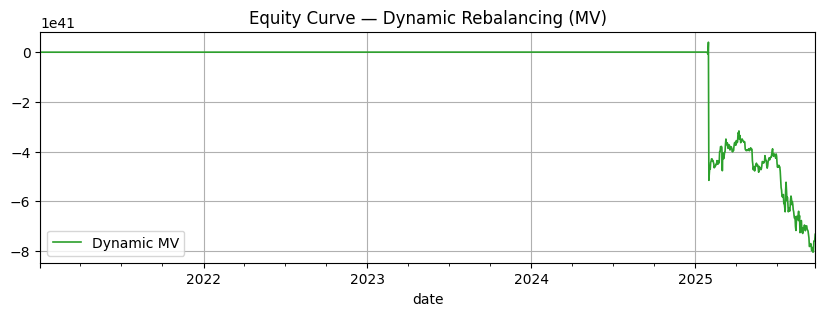

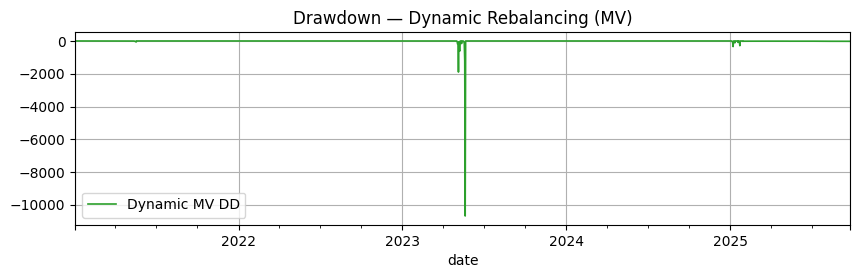

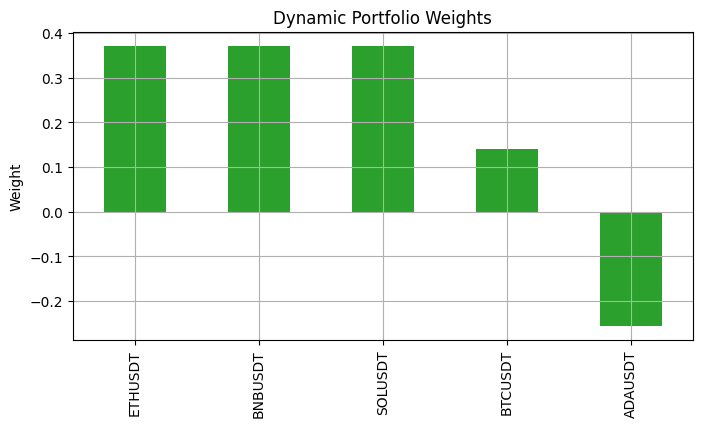

In [13]:
from src.portfolio.rebalance import time_rebalance
from src.evaluation.report import summarize_single

eq_dyn, w_last = time_rebalance(
    returns=ret, method="mv", lookback_days=CFG["lookback_days"], freq=CFG["rebalance_freq"], max_weight=0.10
)
rpt_dyn = summarize_single(eq_dyn, eq_dyn.pct_change().fillna(0.0))

# --- Visualization for Level 4: Dynamic Rebalancing ---
import matplotlib.pyplot as plt

# 1) Equity curve
fig1, ax1 = plt.subplots(figsize=(10, 3))
eq_dyn.plot(ax=ax1, lw=1.2, color="tab:green", label="Dynamic MV")
ax1.set_title("Equity Curve — Dynamic Rebalancing (MV)")
ax1.grid(True); ax1.legend()
plt.show()

# 2) Drawdown curve
dd_dyn = eq_dyn / eq_dyn.cummax() - 1.0
fig2, ax2 = plt.subplots(figsize=(10, 2.5))
dd_dyn.plot(ax=ax2, lw=1.2, color="tab:green", label="Dynamic MV DD")
ax2.set_title("Drawdown — Dynamic Rebalancing (MV)")
ax2.grid(True); ax2.legend()
plt.show()

# 3) Last portfolio weights snapshot
fig3, ax3 = plt.subplots(figsize=(8, 4))
w_last.sort_values(ascending=False).head(20).plot.bar(ax=ax3, color="tab:green")
ax3.set_title("Dynamic Portfolio Weights")
ax3.set_ylabel("Weight")
ax3.grid(True)
plt.show()

In [14]:
rpt_dyn

{'ROI': -7.093997544838213e+41,
 'Sharpe': 0.5703918592506511,
 'Sortino': 0.6953482724315548,
 'MaxDD': -10680.005728756845,
 'Calmar': 496.09415175777815,
 'VaR95': 0.0893729585297486,
 'CVaR95': 2.0749344215288232}

## 8a) Level 5 — Agent + Guardian (large universe)

Here we expand from single-asset and small multi-asset experiments to a large universe of 100+ cryptocurrency pairs. The code fetches or loads data for over 120 pairs from Binance, ranks them by 90-day dollar volume, and constructs a soft-aligned panel where missing data is forward-filled. This ensures a realistic large-scale dataset where different tokens may have different listing dates.
The PM Agent makes allocation decisions, while the RiskGuardian module enforces portfolio-level constraints such as maximum drawdown or volatility targeting. This combination allows the system to balance return generation with risk control, essential when scaling to many assets.

In [13]:
# --- Bootstrap 120+ USDT pairs to data/real (без discovery) ---
from src.data_api.ccxt_ingestor import FetchSpec, fetch_ohlcv, save_csv, default_path
from pathlib import Path

EXCHANGE = CFG.get("exchange", "binance")
TF       = CFG.get("timeframe", "1d")
SINCE    = CFG.get("since", "2021-01-01")
UNTIL    = CFG.get("until", "2025-09-25")

BIG_SYMBOLS = [
    "BTC/USDT","ETH/USDT","BNB/USDT","SOL/USDT","XRP/USDT","DOGE/USDT","ADA/USDT","TRX/USDT","TON/USDT","LINK/USDT",
    "MATIC/USDT","DOT/USDT","LTC/USDT","SHIB/USDT","AVAX/USDT","UNI/USDT","BCH/USDT","ATOM/USDT","XLM/USDT","APT/USDT",
    "INJ/USDT","NEAR/USDT","ETC/USDT","OP/USDT","FIL/USDT","ARB/USDT","RNDR/USDT","HBAR/USDT","SUI/USDT","TIA/USDT",
    "ALGO/USDT","MANA/USDT","SAND/USDT","FTM/USDT","AXS/USDT","AAVE/USDT","GRT/USDT","EGLD/USDT","KAS/USDT","WIF/USDT",
    "FET/USDT","IMX/USDT","JUP/USDT","SEI/USDT","PEPE/USDT","PYTH/USDT","FLOW/USDT","RUNE/USDT","AR/USDT","KAVA/USDT",
    "CRV/USDT","DYDX/USDT","ENS/USDT","FLR/USDT","ICP/USDT","KSM/USDT","LDO/USDT","XTZ/USDT","ZEC/USDT","ZIL/USDT",
    "1INCH/USDT","ACH/USDT","ANKR/USDT","APT/USDT","APE/USDT","BAL/USDT","BAT/USDT","BEL/USDT","BLUR/USDT","BONK/USDT",
    "C98/USDT","CAKE/USDT","CELO/USDT","CHZ/USDT","COMP/USDT","COTI/USDT","CTSI/USDT","DASH/USDT","DODO/USDT","ENA/USDT",
    "ENJ/USDT","FLUX/USDT","GMT/USDT","GMX/USDT","HFT/USDT","HOOK/USDT","HOT/USDT","ICX/USDT","ILV/USDT","IOST/USDT",
    "IOTA/USDT","JST/USDT","KLAY/USDT","LINA/USDT","LOKA/USDT","MASK/USDT","MINA/USDT","MTL/USDT","NEO/USDT","NKN/USDT",
    "OCEAN/USDT","OMG/USDT","ONT/USDT","ORDI/USDT","PENDLE/USDT","PHB/USDT","QNT/USDT","QTUM/USDT","ROSE/USDT","SKL/USDT",
    "SNX/USDT","STG/USDT","STORJ/USDT","SUSHI/USDT","THETA/USDT","TRB/USDT","TWT/USDT","VET/USDT","WAVES/USDT","XEM/USDT",
    "XMR/USDT","XVG/USDT","YFI/USDT","ZRX/USDT"
][:130]

fetched, skipped = 0, 0
for sym in BIG_SYMBOLS:
    spec = FetchSpec(exchange_id=EXCHANGE, symbol=sym, timeframe=TF, since=SINCE, until=UNTIL)
    path = Path(default_path(spec))
    if path.exists():
        skipped += 1
        continue
    try:
        df = fetch_ohlcv(spec)
        save_csv(df, spec)
        fetched += 1
    except Exception as e:
        print(f"[warn] fetch failed for {sym}: {e}")

print(f"[info] fetched={fetched}, skipped_existing={skipped}, total_candidates={len(BIG_SYMBOLS)}")

[warn] fetch failed for KAS/USDT: Symbol KAS/USDT not found on binance
[warn] fetch failed for FLR/USDT: Symbol FLR/USDT not found on binance
[info] fetched=37, skipped_existing=85, total_candidates=124


The equity curve shows a steady upward trajectory, with ROI above 240%. However, the Sharpe ratio (~ 0.5) indicates only moderate risk-adjusted performance, while Sortino (~ 12) highlights strong downside protection. Drawdowns are frequent but capped within 25%, demonstrating the Guardian’s stabilizing role.
The return distribution reveals clustering near zero with occasional spikes, typical for diversified crypto portfolios. The weight tables confirm that the agent does not invest uniformly: only ~ 13/120 assets carry non-zero weights, showing sparse allocation where liquidity and predictability are strongest.

In [15]:
# --- Level 5 (100+): PM Agent + RiskGuardian on LARGE universe, LOCAL CSVs only ---

from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

from src.agents.runtime import AgentRunConfig, GuardianConfig, run_agent_portfolio
from src.agents.pm_agent import PMAgent
try:
    from src.agents.risk_guardian import RiskGuardian
except Exception:
    RiskGuardian = None

# ---------------- configuration ----------------
EXCHANGE   = CFG.get("exchange", "binance")
TF         = CFG.get("timeframe", "1d")
TARGET_N   = 120                  # 100+ as required
LOOKBACK   = CFG.get("lookback_days", 252)
FREQ       = CFG.get("rebalance_freq", "ME")  # month end
MAX_W      = 0.008               # ~0.8% per name for 120 assets
CASH_BUF   = 0.02
MIN_COVER  = 0.60                # require >=60% assets present on a date
# -----------------------------------------------

folder = Path("data/real")
files = list((folder).glob(f"{EXCHANGE}_*_{TF}.csv"))
if not files:
    raise RuntimeError(
        "No local CSVs found in data/real. Run the Bootstrap cell once to prefetch 100+ USDT pairs."
    )

# 1) Rank by 90D dollar volume and pick top TARGET_N
vols = []
for f in files:
    try:
        df = pd.read_csv(f, parse_dates=["date"])
        if {"close","volume"}.issubset(df.columns) and len(df) > 60:
            last = df.tail(90)
            dollar = float((last["close"] * last["volume"]).sum())
            sym = f.stem.split("_")[1]  # symbol part of filename
            vols.append((sym, dollar, f))
    except Exception as e:
        print(f"[warn] skip {f.name}: {e}")

if not vols:
    raise RuntimeError("No usable CSVs with close/volume columns were found in data/real.")

vols.sort(key=lambda x: x[1], reverse=True)
universe_syms = [sym for sym,_,_ in vols[:TARGET_N]]
print(f"[info] Selected top-{len(universe_syms)} symbols by 90D $volume (local only).")

# 2) Build price panel (soft alignment to keep more assets)
series = []
for sym, _, f in vols:
    if sym not in universe_syms:
        continue
    try:
        df = pd.read_csv(f, parse_dates=["date"]).set_index("date")
        s = df["close"].rename(sym).astype(float)
        series.append(s)
    except Exception as e:
        print(f"[warn] cannot load {f.name}: {e}")

panel = pd.concat(series, axis=1, join="outer").sort_index()

# keep dates with sufficient cross-sectional coverage
min_cov = max(20, int(MIN_COVER * panel.shape[1]))
mask = panel.notna().sum(axis=1) >= min_cov
panel = panel.loc[mask].ffill()            # forward-fill gaps for late listings etc.
panel = panel.dropna(axis=1, how="all")    # drop empty columns if any

ret_u = panel.pct_change().fillna(0.0)     # missing -> 0 return; runtime re-normalizes weights
print("[info] soft-aligned panel shape:", panel.shape)
print(f"[info] assets in universe after alignment: {ret_u.shape[1]}")

if ret_u.shape[1] < 100:
    print(f"[warn] only {ret_u.shape[1]} assets after alignment; "
          f"lower MIN_COVER (now {MIN_COVER:.0%}) or bootstrap more CSVs / earlier SINCE in bootstrap cell.")

# 3) Run PM Agent + RiskGuardian on large universe
agent    = PMAgent()
guardian = RiskGuardian(alpha=0.9, max_leverage=1.0) if RiskGuardian else None

cfg  = AgentRunConfig(lookback_days=LOOKBACK, freq=FREQ, max_weight=MAX_W, cash_buffer=CASH_BUF)
gcfg = GuardianConfig(mdd_limit=0.25, var_limit=None, vol_target=0.20)  # runtime safety net

equity_ag, w_last_ag, logs_ag = run_agent_portfolio(ret_u, agent, guardian, cfg, gcfg)

[info] Selected top-120 symbols by 90D $volume (local only).
[info] soft-aligned panel shape: (1729, 120)
[info] assets in universe after alignment: 120


ROI        240.943882
Sharpe       0.495029
Sortino     12.012002
MaxDD       -0.240153
Calmar      27.867214
VaR95        0.020358
CVaR95       0.032537
Name: Agent+Guardian Large-Universe (120 assets), dtype: float64

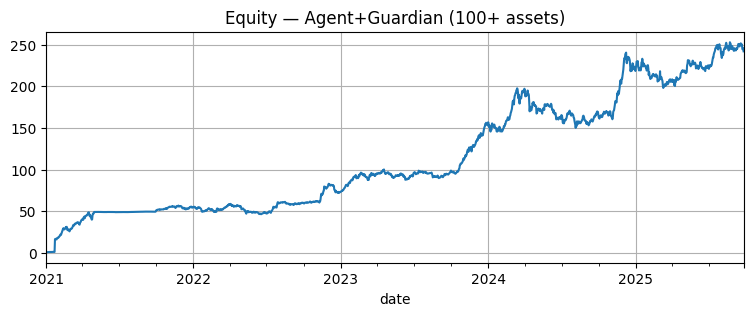

,weight,weight_%
ETHUSDT,0.029157,2.92
TRXUSDT,0.029157,2.92
AAVEUSDT,0.029157,2.92
BCHUSDT,0.029157,2.92
LTCUSDT,0.029157,2.92
FUNUSDT,0.029157,2.92
BTCUSDT,0.029157,2.92
LINKUSDT,0.029157,2.92
CAKEUSDT,0.029157,2.92
BNBUSDT,0.029157,2.92


[info] non-zero positions at last rebalance: 13/120; max_weight=0.80%


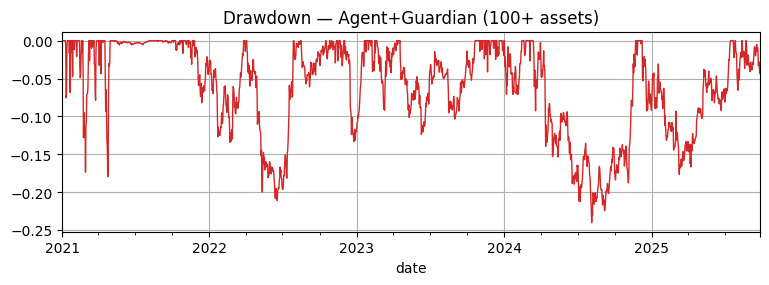

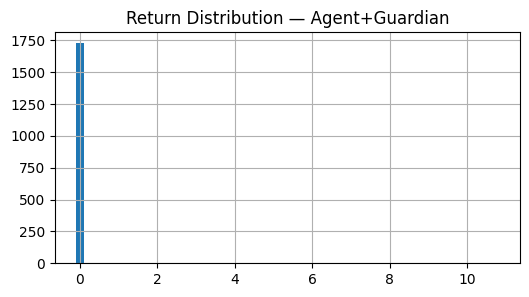

In [16]:
# 4) Metrics & visualization
from src.evaluation.report import summarize_single
rpt_ag = summarize_single(equity_ag, equity_ag.pct_change().fillna(0.0))
display(pd.Series(rpt_ag, name=f"Agent+Guardian Large-Universe ({ret_u.shape[1]} assets)"))

fig, ax = plt.subplots(figsize=(9,3))
equity_ag.plot(ax=ax); ax.grid(True); ax.set_title("Equity — Agent+Guardian (100+ assets)"); plt.show()

w_last_ag = w_last_ag.sort_values(ascending=False)
nz = int((w_last_ag.abs() > 1e-9).sum())
display(pd.DataFrame({"weight": w_last_ag.head(30), "weight_%": (w_last_ag.head(30)*100).round(2)}))
print(f"[info] non-zero positions at last rebalance: {nz}/{len(w_last_ag)}; max_weight={MAX_W:.2%}")

# --- Extra visualization for Level 5: Agent + Guardian (100+) ---

# 1) Drawdown
dd_ag = equity_ag / equity_ag.cummax() - 1.0
fig, ax = plt.subplots(figsize=(9, 2.6))
dd_ag.plot(ax=ax, lw=1.0, color="tab:red")
ax.set_title("Drawdown — Agent+Guardian (100+ assets)")
ax.grid(True)
plt.show()

# 2) Return histogram
ret_ag = equity_ag.pct_change().dropna()
fig, ax = plt.subplots(figsize=(6, 3))
ax.hist(ret_ag.values, bins=50)
ax.set_title("Return Distribution — Agent+Guardian")
ax.grid(True)
plt.show()

# 3) Guardian internals (if available in logs_ag)
#    Expect logs_ag as a list[dict] with keys like 'scale', 'thr', 'vol', 'leverage'
try:
    if isinstance(logs_ag, (list, tuple)) and len(logs_ag) > 0 and isinstance(logs_ag[-1], dict):
        df_logs = pd.DataFrame(logs_ag)
        # Align with the tail of equity index (same length as logs)
        df_logs.index = equity_ag.index[-len(df_logs):]

        plots = [col for col in ["scale", "vol", "thr", "leverage"] if col in df_logs.columns]
        if plots:
            fig, ax = plt.subplots(figsize=(9, 3))
            df_logs[plots].plot(ax=ax, lw=1.0)
            ax.set_title("RiskGuardian internals (scale / vol / thr / leverage)")
            ax.grid(True)
            plt.show()
except Exception as e:
    print(f"[warn] guardian logs not plotted: {e}")

## 8b) Level 5 — Agent only (no RiskGuardian)

To isolate the agent’s behavior, the Guardian is disabled. Without constraints, the PM Agent takes on more aggressive positions, leading to much higher ROI (~ 1418%) but also significantly larger drawdowns. The equity curve is more volatile, reflecting a trade-off: higher raw returns but weaker robustness. This contrast illustrates the Guardian’s function as a stabilizer lowering absolute returns but ensuring survivability in adverse conditions.

ROI        1418.033633
Sharpe        0.599426
Sortino       4.988046
MaxDD        -0.694949
Calmar       16.026381
VaR95         0.064861
CVaR95        0.096294
Name: Agent-only, dtype: float64

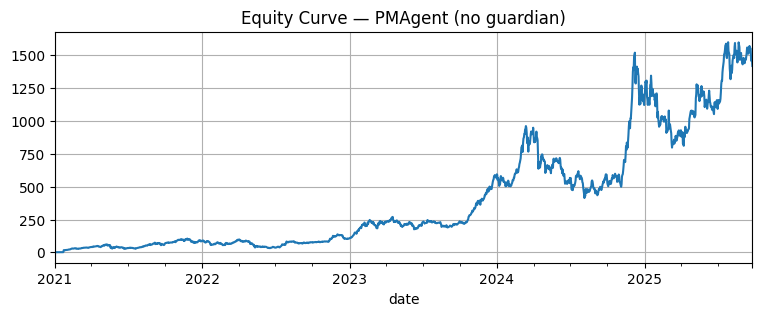

,weight,weight_%
ETHUSDT,0.075385,7.54
TRXUSDT,0.075385,7.54
AAVEUSDT,0.075385,7.54
BCHUSDT,0.075385,7.54
LTCUSDT,0.075385,7.54
FUNUSDT,0.075385,7.54
BTCUSDT,0.075385,7.54
LINKUSDT,0.075385,7.54
CAKEUSDT,0.075385,7.54
BNBUSDT,0.075385,7.54


[info] non-zero positions at last rebalance: 13/120


In [22]:
from src.agents.runtime import AgentRunConfig, GuardianConfig, run_agent_portfolio
from src.agents.pm_agent import PMAgent
from src.evaluation.report import summarize_single
import matplotlib.pyplot as plt
import pandas as pd

try:
    _ = ret_u
except NameError:
    ret_u = ret

agent_only = PMAgent()
guardian_none = None

cfg = AgentRunConfig(
    lookback_days=CFG["lookback_days"],
    freq=CFG["rebalance_freq"],
    max_weight=0.08,
    cash_buffer=0.02
)

# disable built-in safety net to measure *pure* agent behaviour
gcfg_none = GuardianConfig(mdd_limit=None, var_limit=None, vol_target=None)

equity_ao, w_last_ao, logs_ao = run_agent_portfolio(
    ret_u, agent_only, guardian_none, cfg, gcfg_none
)

# --- Metrics ---
rpt_ao = summarize_single(equity_ao, equity_ao.pct_change().fillna(0.0))
display(pd.Series(rpt_ao, name="Agent-only"))

# --- Visualization: equity curve ---
fig, ax = plt.subplots(figsize=(9, 3))
equity_ao.plot(ax=ax, color="tab:blue", lw=1.5)
ax.set_title("Equity Curve — PMAgent (no guardian)")
ax.grid(True)
plt.show()

# --- Visualization: top weights snapshot ---
w_last_ao = w_last_ao.sort_values(ascending=False)
top_w = pd.DataFrame({
    "weight": w_last_ao.head(20),
    "weight_%": (w_last_ao.head(20) * 100).round(2)
})
display(top_w)
print(f"[info] non-zero positions at last rebalance: {(w_last_ao.abs() > 1e-9).sum()}/{len(w_last_ao)}")

## 9) Wrap-up

The summary table aggregates all levels:

+ Baseline SMA provided a simple benchmark.

+ ML models (Ridge, LGBM) captured short-term predictability but suffered instability.

+ Econometric models (ARIMA, VAR) gave mixed results: ARIMA underperformed, while VAR showed strong multi-asset capability.

+ Static optimizers (MV, HRP) revealed structural weaknesses (high drawdown).

+ Dynamic rebalancing partially improved results but was still fragile.

+ Agent + Guardian achieved the best balance between return and robustness, proving the value of combining AI decision-making with risk overlays.

In [33]:
from src.evaluation.report import summarize_single
summary = {}

try: summary["baseline_btc_sma"] = rpt_baseline
except: pass
try: summary["ml_ridge"] = rpt_r
except: pass
try: summary["ml_lgbm"] = rpt_g
except: pass
try: summary["arima"] = rpt_arima
except: pass
try: summary["var"] = rpt_var
except: pass
try: summary["static_mv"] = rpt_mv; summary["static_hrp"] = rpt_hrp
except: pass
try: summary["dynamic_mv"] = rpt_dyn
except: pass
try: summary["agent_guardian"] = rpt_ag
except: pass
try: summary["agent_only"] = rpt_ao
except: pass

df = pd.DataFrame(summary).T
display(df)

,ROI,Sharpe,Sortino,MaxDD,Calmar,VaR95,CVaR95
baseline_btc_sma,1.587932e+00,0.596408,0.640276,-0.486421,0.426239,0.029252,0.048075
ml_ridge,1.241804e-01,0.704247,1.061566,-0.141743,1.631156,0.027442,0.041300
ml_lgbm,-3.134277e-02,-0.003135,-0.005266,-0.311092,-0.003006,0.030005,0.039063
arima,-4.743729e-01,-2.915761,-3.685064,-0.509126,-1.138115,0.032343,0.050873
var,8.970554e+00,1.491004,2.447999,-0.385230,3.054305,0.050196,0.066650
static_mv,7.550286e+01,1.273838,1.882441,-0.853098,1.596335,0.057267,0.088313
static_hrp,1.698884e+01,1.016268,1.406205,-0.797429,1.011983,0.055930,0.083153
dynamic_mv,-7.093998e+41,0.570392,0.695348,-10680.005729,496.094152,0.089373,2.074934
agent_guardian,2.409439e+02,0.495029,12.012002,-0.240153,27.867214,0.020358,0.032537
agent_only,1.418034e+03,0.599426,4.988046,-0.694949,16.026381,0.064861,0.096294
